# Extended K-NN & SVM prediction project

#### Oliver Gatland

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
import random
from datetime import datetime
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import StandardScaler, RobustScaler, TargetEncoder
from sklearn.decomposition import PCA

In [2]:
# Loading data
df_train = pd.read_csv("dl24-probability-of-death-with-k-nn/mimic_train.csv")
df_test = pd.read_csv("dl24-probability-of-death-with-k-nn/mimic_test_death.csv")

# Preprocessing

In [3]:
df_train.columns

Index(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id',
       'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'DOB', 'DOD', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'Diff', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis',
       'FIRST_CAREUNIT', 'LOS'],
      dtype='object')

In [4]:
df_test.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'GENDER', 'DOB',
       'ADMITTIME', 'Diff', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis',
       'FIRST_CAREUNIT'],
      dtype='object')

In [5]:
# Remove columns in the train data not present in the test (but keep death flag)
common_columns = df_train.columns.intersection(df_test.columns)
df_train = df_train[list(common_columns) + ['HOSPITAL_EXPIRE_FLAG']]

We just use the mean of the numeric variables. I experimented with adding the min and max but it did not improve the out of sample prediction.

In [6]:
# Keep only mean numerical variables
df_train.drop(columns=[col for col in df_train.columns if col.endswith('Min') or col.endswith('Max')], inplace=True)
df_test.drop(columns=[col for col in df_test.columns if col.endswith('Min') or col.endswith('Max')], inplace=True)

### Missing values

In [7]:
# Check missing values in train
df_train.isna().sum()

subject_id                 0
hadm_id                    0
icustay_id                 0
HeartRate_Mean          2187
SysBP_Mean              2208
DiasBP_Mean             2209
MeanBP_Mean             2186
RespRate_Mean           2189
TempC_Mean              2497
SpO2_Mean               2203
Glucose_Mean             253
GENDER                     0
DOB                        0
ADMITTIME                  0
Diff                       0
ADMISSION_TYPE             0
INSURANCE                  0
RELIGION                   0
MARITAL_STATUS           722
ETHNICITY                  0
DIAGNOSIS                  0
ICD9_diagnosis             0
FIRST_CAREUNIT             0
HOSPITAL_EXPIRE_FLAG       0
dtype: int64

In [8]:
# Check missing values in test
df_test.isna().sum()

subject_id          0
hadm_id             0
icustay_id          0
HeartRate_Mean    545
SysBP_Mean        551
DiasBP_Mean       552
MeanBP_Mean       547
RespRate_Mean     546
TempC_Mean        638
SpO2_Mean         551
Glucose_Mean       58
GENDER              0
DOB                 0
ADMITTIME           0
Diff                0
ADMISSION_TYPE      0
INSURANCE           0
RELIGION            0
MARITAL_STATUS    180
ETHNICITY           0
DIAGNOSIS           0
ICD9_diagnosis      0
FIRST_CAREUNIT      0
dtype: int64

Only cols with missing values are the numericals and marital status. Numericals will be imputed with KNN, marital status is investigated further below.

### Categorical variables

Investigating the following columns that are likely to be appropriate for one hot encoding: 'GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'MARITAL_STATUS'. If possible, it is best to one hot encode categorical variables as it allows us to capture the variation for each category within the model. The main downside is it can often increase the dimensionality of the data, as we add a new column for each possible value of the variable. If there is a high number of unique values for a variable, using one hot encoding would significantly increase the dimensionality of the data. This is computationally expensive, but can also impact the predictive performance of a model, known as the 'curse of dimensionality'.

Below I check the number of values for each of these variables, and if there is a low number of unique values, and if each value has a sufficient number of observations, I will one hot encode them. 

In [9]:
print(df_train['GENDER'].unique())
print(df_train['ADMISSION_TYPE'].unique())
print(df_train['INSURANCE'].unique())
print(df_train['MARITAL_STATUS'].unique())

['F' 'M']
['EMERGENCY' 'ELECTIVE' 'URGENT']
['Medicare' 'Private' 'Medicaid' 'Self Pay' 'Government']
['SINGLE' 'MARRIED' 'SEPARATED' 'WIDOWED' 'DIVORCED' nan
 'UNKNOWN (DEFAULT)' 'LIFE PARTNER']


In [10]:
print(df_train['GENDER'].value_counts())
print(df_train['ADMISSION_TYPE'].value_counts())
print(df_train['INSURANCE'].value_counts())
print(df_train['MARITAL_STATUS'].value_counts())

GENDER
M    11759
F     9126
Name: count, dtype: int64
ADMISSION_TYPE
EMERGENCY    17817
ELECTIVE      2848
URGENT         220
Name: count, dtype: int64
INSURANCE
Medicare      11718
Private        6245
Medicaid       2117
Government      611
Self Pay        194
Name: count, dtype: int64
MARITAL_STATUS
MARRIED              9664
SINGLE               5910
WIDOWED              2819
DIVORCED             1413
SEPARATED             240
UNKNOWN (DEFAULT)     103
LIFE PARTNER           14
Name: count, dtype: int64


All have sufficient values for one hot encoding aside from 'LIFE PARTNER' for marital status. I will combine this with the UNKNOWN column to form a 'other' category.

In [11]:
# Creating 'other' category in marital status
df_train['MARITAL_STATUS'] = df_train['MARITAL_STATUS'].replace(['UNKNOWN (DEFAULT)', 'LIFE PARTNER'], 'OTHER')
df_test['MARITAL_STATUS'] = df_test['MARITAL_STATUS'].replace(['UNKNOWN (DEFAULT)', 'LIFE PARTNER'], 'OTHER')

As mentioned previously, marital status was the only non-numeric variable with missing values. I look if the patients with missing values tend to have a different death rate.

In [12]:
df_train['MARITAL_STATUS'].fillna('MISSING', inplace=True)
mean_values = df_train .groupby('MARITAL_STATUS')['HOSPITAL_EXPIRE_FLAG'].mean()
print(mean_values)

MARITAL_STATUS
DIVORCED     0.113942
MARRIED      0.111755
MISSING      0.254848
OTHER        0.222222
SEPARATED    0.108333
SINGLE       0.081218
WIDOWED      0.137637
Name: HOSPITAL_EXPIRE_FLAG, dtype: float64


It appears those with NAs have a higher probability of death than the other categories, since the average probability of death is similar to OTHER, I will fill all NaN values with OTHER.

In [13]:
df_train['MARITAL_STATUS'] = df_train['MARITAL_STATUS'].replace('MISSING', 'OTHER')
df_test['MARITAL_STATUS'].fillna('OTHER', inplace=True)

Now I look into the religion and ethnicity variables, as these may have too many unique values to one hot encode.

In [14]:
# Checking the number of unique religions
df_train['RELIGION'].value_counts()

RELIGION
CATHOLIC                  7655
NOT SPECIFIED             5398
PROTESTANT QUAKER         2753
JEWISH                    1840
UNOBTAINABLE              1515
OTHER                      702
EPISCOPALIAN               288
GREEK ORTHODOX             178
CHRISTIAN SCIENTIST        164
BUDDHIST                   109
MUSLIM                      74
UNITARIAN-UNIVERSALIST      54
JEHOVAH'S WITNESS           45
ROMANIAN EAST. ORTH         41
HINDU                       38
7TH DAY ADVENTIST           30
HEBREW                       1
Name: count, dtype: int64

There are enough values for most religions to justify one hot encoding, but I add all religions with less than 100 followers to the 'other' category to reduce dimensions.

In [15]:
# Grouping toegther smaller religions
df_train['RELIGION'] = df_train['RELIGION'].replace(['MUSLIM', 'UNITARIAN-UNIVERSALIST', "JEHOVAH'S WITNESS", 'ROMANIAN EAST. ORTH', 'HINDU', '7TH DAY ADVENTIST', 'HEBREW'], 'OTHER')
df_test['RELIGION'] = df_test['RELIGION'].replace(['MUSLIM', 'UNITARIAN-UNIVERSALIST', "JEHOVAH'S WITNESS", 'ROMANIAN EAST. ORTH', 'HINDU', '7TH DAY ADVENTIST', 'HEBREW'], 'OTHER')

In [16]:
# Checking the number of unique ethnicities
df_train['ETHNICITY'].value_counts()

ETHNICITY
WHITE                                                       15112
BLACK/AFRICAN AMERICAN                                       1977
UNABLE TO OBTAIN                                              577
UNKNOWN/NOT SPECIFIED                                         568
HISPANIC OR LATINO                                            562
OTHER                                                         489
ASIAN                                                         265
PATIENT DECLINED TO ANSWER                                    175
HISPANIC/LATINO - PUERTO RICAN                                155
ASIAN - CHINESE                                               146
BLACK/CAPE VERDEAN                                            126
WHITE - RUSSIAN                                               117
BLACK/HAITIAN                                                  72
HISPANIC/LATINO - DOMINICAN                                    59
ASIAN - ASIAN INDIAN                                           58


There are too many different values for ethnicity to one hot encode. I group these into similar ethnicities to reduce the dimensionality.

In [17]:
# Grouping major ethnic groups
ethnic_groups = ['WHITE', 'BLACK', 'HISPANIC', 'ASIAN']

for group in ethnic_groups:
    df_train.loc[df_train['ETHNICITY'].str.contains(group), 'ETHNICITY'] = group
    df_test.loc[df_test['ETHNICITY'].str.contains(group), 'ETHNICITY'] = group


# Combining the two 'unknown' variables
df_train['ETHNICITY'] = df_train['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'UNKNOWN/NOT SPECIFIED'], 'UNKNOWN')
df_test['ETHNICITY'] = df_test['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'UNKNOWN/NOT SPECIFIED'], 'UNKNOWN')

# Adding anything with less than 100 obvs into the 'other' category
ethnicity_counts = df_train['ETHNICITY'].value_counts()
ethnicities_to_replace = ethnicity_counts[ethnicity_counts < 100].index.tolist()
df_train.loc[df_train['ETHNICITY'].isin(ethnicities_to_replace), 'ETHNICITY'] = 'OTHER'
df_test.loc[df_test['ETHNICITY'].isin(ethnicities_to_replace), 'ETHNICITY'] = 'OTHER'

In [18]:
df_train['ETHNICITY'].value_counts()

ETHNICITY
WHITE                         15330
BLACK                          2201
UNKNOWN                        1145
HISPANIC                        852
OTHER                           637
ASIAN                           545
PATIENT DECLINED TO ANSWER      175
Name: count, dtype: int64

Now we have grouped the ethnicities so they can be one hot encoded. All categorical variables are one hot encoded later in the notebook.

### ICD9 variable

The ICD9 column only contains the main diagnosis, we can load the extra data which has further diagnosis' for the patient.

In [19]:
# Load meta data
data_meta = pd.read_csv("dl24-probability-of-death-with-k-nn/extra_data/MIMIC_diagnoses.csv")  
data_meta = data_meta.rename(columns= {'ICD9_CODE': 'ICD9_diagnosis', 'SUBJECT_ID': 'subject_id', 'HADM_ID': 'hadm_id'})

data_meta

,subject_id,hadm_id,SEQ_NUM,ICD9_diagnosis
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859
...,...,...,...,...
651042,65535,178280,5.0,5119
651043,65535,178280,6.0,5990
651044,65535,178280,7.0,0414
651045,65535,178280,8.0,25000


Where SEQ = 1 we have the same information that is in the original dataset, so these are dropped. I also only keep the top 10 diagnosis as some patients have a large number of ICD9 numbers.

In [20]:
data_meta = data_meta[data_meta['SEQ_NUM'].between(2, 10)]

Now we merge the secondary ICD9 numbers into the main dataset.

In [21]:
data_meta = data_meta.pivot(index=['subject_id', 'hadm_id'], columns= 'SEQ_NUM', values='ICD9_diagnosis')
data_meta = data_meta.reset_index()

# Rename columns 
data_meta.columns = ['subject_id'] + ['hadm_id'] + [f'ICD9_{col}' for col in data_meta.columns[2:]]

# Merge in columns
df_train = df_train.merge(data_meta, on=['subject_id', 'hadm_id'], how='left')
df_test = df_test.merge(data_meta, on=['subject_id', 'hadm_id'], how='left')

# Rename original ICD9 col
df_train.rename(columns={'ICD9_diagnosis': 'ICD9_1.0'}, inplace=True)
df_test.rename(columns={'ICD9_diagnosis': 'ICD9_1.0'}, inplace=True)

There are too many ICD9 cols and values to use one hot encoding. One other option for categorical variables of this nature is to use target encoding. This condenses the information within categorical variables into a single feature that represents the mean of some target value. In this case, I use the death flag as the target variable, so each ICD9 value is represented by the probability that a patient with this diagnosis died. This ensures that patients with more severe diagnoses are represented closer in the models feature space. 

Targt encoding can lead to overfitting, so to mitigate against this I use smoothing, where the target encoding is a blend of the category mean and the overall mean of the target variable. The balance between the category-specific mean and the overall mean is determined by the number of samples for each category. As the number of samples for a category decreases, the contribution of the category-specific mean decreases, and the contribution of the overall mean increases, leading to more stable estimates.

In [22]:
target_cols = [f'ICD9_{i}.0' for i in range(1, 11)]

# Target encode each ICD9 col
for col in target_cols:
    encoder = TargetEncoder(smooth="auto")
    values = encoder.fit_transform(X=df_train[[col]], y=df_train['HOSPITAL_EXPIRE_FLAG'])
    values = encoder.transform(X=df_train[[col]])
    df_train[f'{col}_encoded'] = values

In [23]:
# Extract target encoded values to input into test data
encoded_cols = [f'ICD9_{i}.0_encoded' for i in range(1, 11)]

unique_pairs_dict = {}
for column, encoding in zip(target_cols, encoded_cols):
    unique_pairs = df_train[[column, encoding]].drop_duplicates().sort_values(by=encoding)
    unique_pairs_dict[column] = unique_pairs

# Merge encoded values with df_test for each column
for column, encoding in zip(target_cols, encoded_cols):
    df_test = df_test.merge(unique_pairs_dict[column][[column, encoding]], on=column, how='left')

In [24]:
# Drop unencoded variables
df_train.drop(target_cols,  axis=1, inplace = True)
df_test.drop(target_cols,  axis=1, inplace = True)

We have now target encoded multiple ICD9 columns. To reduce the dimensionality I just keep the primary ICD9 target encoding, then average over all the secondary ICD9 diagnosis columns.

In [25]:
icd9_mean_cols = [f'ICD9_{i}.0_encoded' for i in range(2, 11)]

# Compute mean of those columns and add as a new column
df_train['ICD9_secondary'] = df_train[icd9_mean_cols].mean(axis=1)
df_test['ICD9_secondary'] = df_test[icd9_mean_cols].mean(axis=1)

# Drop secondary diagnosis cols
df_train.drop(icd9_mean_cols,  axis=1, inplace = True)
df_test.drop(icd9_mean_cols,  axis=1, inplace = True)

### One hot encoding

In [26]:
# Define cols to one hot encode
one_hot_columns = ['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'MARITAL_STATUS', 'RELIGION', 'ETHNICITY']

In [27]:
# One-hot encoding
df_train = pd.get_dummies(df_train, columns = one_hot_columns)
df_test = pd.get_dummies(df_test, columns = one_hot_columns)

# Print columns that were dropped
print("Categorical columns dropped:", one_hot_columns)

Categorical columns dropped: ['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'MARITAL_STATUS', 'RELIGION', 'ETHNICITY']


### Creating age variable

The DOB and admission time can be used to create a variable showing the age at admission.

In [28]:
# Process DOB column
df_train['DOB'] = pd.to_datetime(df_train['DOB'])
df_test['DOB'] = pd.to_datetime(df_test['DOB'])

df_train['DOB'] = df_train['DOB'] + pd.to_timedelta(df_train['Diff'], unit='D')
df_test['DOB'] = df_test['DOB'] + pd.to_timedelta(df_test['Diff'], unit='D')

# Remove outliers 
df_train.loc[df_train['DOB'].dt.year < 1880, 'DOB'] = None
df_test.loc[df_test['DOB'].dt.year < 1880, 'DOB'] = None

# Process ADMITTIME column
df_train['ADMITTIME'] = pd.to_datetime(df_train['ADMITTIME'])
df_test['ADMITTIME'] = pd.to_datetime(df_test['ADMITTIME'])

df_train['ADMITTIME'] = df_train['ADMITTIME'] + pd.to_timedelta(df_train['Diff'], unit='D')
df_test['ADMITTIME'] = df_test['ADMITTIME'] + pd.to_timedelta(df_test['Diff'], unit='D')

## Calculate age
df_train['AGE'] = df_train['ADMITTIME'].dt.year - df_train['DOB'].dt.year
df_test['AGE'] = df_test['ADMITTIME'].dt.year - df_test['DOB'].dt.year

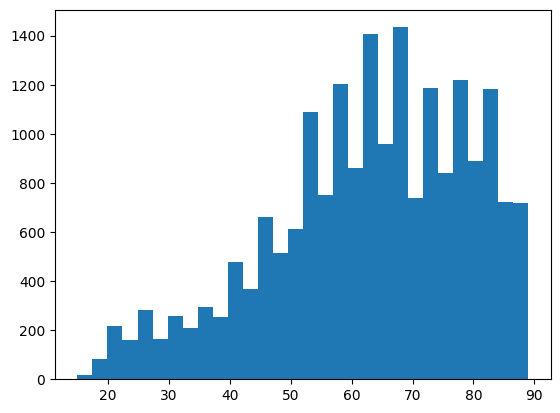

In [29]:
# Checking distribution of age
plt.hist(df_train['AGE'], bins=30);

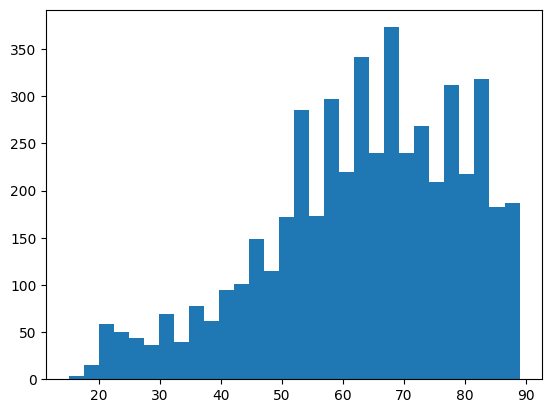

In [30]:
plt.hist(df_test['AGE'], bins=30);

The distribution of ages looks as expected. We created some NaN values which will be imputed below.

### Scaling variables

Scaling the data is very important when using algorithms like KNN which try to determine how close two observations are in euclidean space. Scaling the data ensures each feature contributes equally to the calculation of distance. Without scaling features with larger scales would have greater influence on the model.

Below I use robust scaling which uses the median and quantile range to scale the data. This approach is more sensitive to outliers so will control for the presence of outliers in some of the features.

The columns_to_scale variable below also determines what features will be included in the modelling. Notice that the religion and ethnicity variables are excluded as after experimenting, the inclusion of these variables reduced the out of sample performance of the models. 

In [31]:
# Scaling numerical and binary variables
columns_to_scale = ['HeartRate_Mean', 'SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean', 'TempC_Mean','SpO2_Mean', 'Glucose_Mean', 'GENDER_F','GENDER_M', 
                    'ADMISSION_TYPE_ELECTIVE', 'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_URGENT', 'INSURANCE_Government', 'INSURANCE_Medicaid', 'INSURANCE_Medicare', 
                    'INSURANCE_Private', 'INSURANCE_Self Pay', 'MARITAL_STATUS_DIVORCED', 'MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_OTHER',
                    'MARITAL_STATUS_SEPARATED', 'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_WIDOWED', 'AGE', 'ICD9_1.0_encoded', 'ICD9_secondary']


scaler = preprocessing.RobustScaler()
scaler.fit(df_train[columns_to_scale])
df_train[columns_to_scale] = scaler.transform(df_train[columns_to_scale])
df_test[columns_to_scale] = scaler.transform(df_test[columns_to_scale])

### Imputing

The numerical variables in the data contained missing values. I use KNN imputing to fill these missing values. This works by assuming that similar observations have similar feature values, then taking the average of a set number of neighbors to impute the missing values in the data. Below I use 5 neighbors as after some experimentation this led to the best out of sample performance.

In [32]:
# Imputing missing numerical values with KNN imputer
columns_to_impute = ['HeartRate_Mean', 'SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean', 'TempC_Mean','SpO2_Mean', 'Glucose_Mean', 'AGE', 'ICD9_1.0_encoded', 'ICD9_secondary'] 

imputer = KNNImputer(n_neighbors=5)
df_train[columns_to_impute] = imputer.fit_transform(df_train[columns_to_impute])
df_test[columns_to_impute] = imputer.transform(df_test[columns_to_impute])

### Re-sampling

It is common in classification models for there to be more of one class than another, this is known as class imbalance. Below I check how balanced the death flag is in the data.

In [33]:
df_train['HOSPITAL_EXPIRE_FLAG'].value_counts()

HOSPITAL_EXPIRE_FLAG
0    18540
1     2345
Name: count, dtype: int64

We have a large class imbalance which can lead to problems identifying the minority class. Speficially class imbalance can lead to bias towards the majority class and poor generalization as the model has less of the minority class to train on. To adress these issues we can re-sample the data, where we artifically balance the class we are trying to predict.

Below I use SMOTE-Tomek links to re-sample the classes before modelling. This is a combination of two techniques used to address class imbalance:

- SMOTE: A technique used to oversample the minority class by generating synthetic examples that are similar to existing minority class instances.

- Tomek links: Tomek Links are pairs of instances (one from the majority class and one from the minority class) that are nearest neighbors of each other but belong to different classes. Removing these instances helps to improve the separation between the classes and can make the classification task easier.

After experimenting with the models, re-sampling only improved the performance of the SVM model, so the original data will be used when training the KNN model.

In [34]:
# Subset dataframes with variables to be included in the model (same as cols we scaled)
X_train = df_train[columns_to_scale]
X_test = df_test[columns_to_scale]
y_train = df_train[['HOSPITAL_EXPIRE_FLAG']]

In [35]:
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))

# Resample the dataset
X_train_resampled, y_train_resampled = resample.fit_resample(X_train, y_train)

In [36]:
y_train_resampled['HOSPITAL_EXPIRE_FLAG'].value_counts()

HOSPITAL_EXPIRE_FLAG
1    18540
0    18532
Name: count, dtype: int64

Resampling has achieved class balance ahead of modelling. When using re-sampled data in SVM we need to re-weight the prediction probabilities as we have biased the data. The below function will be used after making predictions to re-weight the probabilities.

In [37]:
# Define function for reweighting probabilities 
def reweight(pi,q1=0.5,r1=0.5):
    r0 = 1-r1
    q0 = 1-q1
    tot = pi*(q1/r1)+(1-pi)*(q0/r0)
    w = pi*(q1/r1)
    w /= tot
    return w

# q1 is the percentage of deaths in the training sample, r1 is the rebalanced percentage of the minority class
q1 = (y_train_resampled.value_counts()/len(y_train_resampled))[1] 
r1 = 0.5

### PCA

I experimented with PCA for dimensionality reduction. PCA reduces the dimensionality of the data while retaining as much of the original variance in the data as possible. This can improve the performance of a model by reducing noise in the data and only preserving the most important variation in each feature.

Below I reduce the dimensionality of the data without re-sampling to 10 features as this improved the out of sample performance of KNN the most. I also experimented with using PCA on the re-sampled data for SVM, but this made the out of sample prediction worse.

In [38]:
# Instantiate PCA
pca = PCA(n_components=10)

# Fit and transform the data 
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [39]:
# Convert to arrays for modelling
y_train_resampled = y_train_resampled.values.ravel()
y_train = y_train.values.ravel()

# KNN model

To train the KNN model I use grid search to find the optimal parameters. This works by testing multiple combinations of parameters, and cross validating against a subset of the data. For KNN I set the algorithm to "brute" which calculates the distance between every other point in the dataset. This is computationally expensive but with datasets that are not too large will find the best solution compared with other algorithms that employ space partitioning data structures to speed up the process. This means I grid search over the following two parameters:
- n_neighbors: Determines the number of neighbors to consider in the calculation
- weights: Determines the weight given to points when calculating the probability of death. Uniform weights all points equally while distance gives more weight to those points which are closer.

For scoring, I use ROC_AUC which is the area under the Receiver Operating Characteristic curve (ROC). The area under this curve summarizes the performance of a binary classifier, giving an indication of the classifiers ability to distinguish between positive and negative classes wihtout using a specific threshold.

In [40]:
knn_model = KNeighborsClassifier(algorithm='brute')

grid_values = {'n_neighbors':[1, 5, 10, 20, 30, 40, 100, 150, 200], 'weights':['uniform','distance']}
grid_knn_acc = GridSearchCV(knn_model, param_grid = grid_values, scoring = 'roc_auc', cv=5)
grid_knn_acc.fit(X_train_pca, y_train)

best_params = grid_knn_acc.best_params_
optimal_neighbors = best_params['n_neighbors']
optimal_weights = best_params['weights']
print('Optimal Number of Neighbors:', optimal_neighbors)
print('Optimal Weight:', optimal_weights)

Optimal Number of Neighbors: 200
Optimal Weight: distance


In [45]:
# Predicting probabilities
knn_probs = grid_knn_acc.predict_proba(X_test_pca)

In [46]:
knn_pred_df = pd.DataFrame({
    'icustay_id': df_test['icustay_id'],
    'HOSPITAL_EXPIRE_FLAG': knn_probs[:, 1]
})

In [47]:
# Save predictions
knn_pred_df.to_csv("C:/Users/gatla/OneDrive/BSE/CL_DL/project_1/knn_predictions.csv", index=False)

# SVM model

SVM aims to find the optimal hyperplane that best separates the data points of different classes in the feature space. I also use grid search over the following parameters to tune my model:
- kernel: Determines the way in which data is transformed into higher dimensional space when the data isn't linearly seperable in its normal state.
- gamma: this only applies to the 'rbf' and 'poly' kernels and it determines the shape of the decision boundary.
- degree: the degree of the polynomial kernel
- C: represents the penalty cost for slack points which is where some data points are allowed to be on the wrong side of the decision boundary. It's an important parameter to tune to prevent overfitting.

The class_weight parameter is used to fix for unbalanced data, however, since I have already re-sampled the data using SMOTE-Tomek links, I set this to none. As mentioned previously, the prediction probabilities will then be re-weighted to account for the bias introduced by re-sampling. For scoring I use ROC_AUC for the same reasons explained above.



In [54]:
X_train_sample = X_train_resampled.sample(n=5000, random_state=42)
y_train_sample = y_train_resampled[X_train_sample.index]

svm_model = SVC(class_weight=None, probability=True)

grid_values = {'kernel': ['linear', 'rbf', 'poly'],
               'gamma': [0.01, 0.05, 0.1],
               'degree': [2,3,4],
               'C': [0.1, 1, 100]}

grid_svc_acc = GridSearchCV(svm_model, param_grid = grid_values, scoring = 'roc_auc', cv=5)

grid_svc_acc.fit(X_train_sample, y_train_sample)

best_params = grid_svc_acc.best_params_
optimal_kernel = best_params['kernel']
optimal_gamma = best_params['gamma']
optimal_degree = best_params['degree']
optimal_C = best_params['C']
print('Optimal Number of Neighbors:', optimal_kernel)
print('Optimal Gamma:', optimal_gamma)
print('Optimal Degree:', optimal_degree)
print('Optimal C:', optimal_C)

Optimal Number of Neighbors: rbf
Optimal Gamma: 0.01
Optimal Degree: 3
Optimal C: 1.5


In [50]:
# Run model with optimal params (params hard coded so grid search doesn't have to be re-run each time the notebook is run)
svm_model = SVC(kernel = 'rbf', C = 1.5, gamma = 0.01, class_weight=None, probability=True)
svm_model.fit(X_train_resampled, y_train_resampled)

SVC(C=1.5, gamma=0.01, probability=True)

In [51]:
# Predict probabilities and re-weight
svm_probs = pd.Series(svm_model.predict_proba(X_test)[:,1]).apply(reweight,args=(q1,r1))
svm_probs = np.column_stack((1 - svm_probs, svm_probs))

In [52]:
svm_pred_df = pd.DataFrame({
    'icustay_id': df_test['icustay_id'],
    'HOSPITAL_EXPIRE_FLAG': svm_probs[:, 1]
})

In [53]:
svm_pred_df.to_csv("C:/Users/gatla/OneDrive/BSE/CL_DL/project_1/svm_predictions.csv", index=False)